In [1]:
library("ggplot2")
library("dplyr",warn.conflicts=FALSE)
library("rjags")
library("stats")
set.seed(1234)

Loading required package: coda

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs



## R exercises
# Set n# 6

### Exercise 1

a well established and diffused method for detecting a disease in blood fails to detect the presence of disease in 15% of the patients that actually have the disease.

A young UniPD startUp has developed an innovative method of screening. During the qualification phase, a random sample of n = 75 patients known to have the disease is screened using the new method.

#### _(a) what is the probability distribution of y, the number of times the new method fails to detect the disease ?_

If the new method has a certain chance $\theta_{failure}$ of NOT detecting the disease, the number of "failures" $y$ in $n$ trials will follow a binomial distribution:

$$
P(y)_n = {n \choose y} \theta_{failure}^{y} (1-\theta_{failure})^{n-y}
$$

#### _(b) on the n = 75 patients sample, the new method fails to detect the disease in y = 6 cases. What is the frequentist estimator of the failure probability of the new method ?_

The frequentist approach would choose the parameter $\theta_{failure}$ as the one that maximizes the likelihood of the observed data, i.e.:

$$
\hat{\theta}_{MLE} = \frac{y}{n}
$$

#### _(c) setup a bayesian computation of the posterior probability, assuming a beta distribution with mean value 0.15 and standard deviation 0.14. Plot the posterior distribution for y, and mark on the plot the mean value and variance_

Recall the Bayes theorem:

$$
Posterior \propto Likelihood \times Prior
$$

Assuming the prior to be a beta distribution for the parameter $\theta$:

$$
Prior = Beta(\theta,\alpha,\beta) = \frac{\theta^{\alpha-1}(1-\theta)^{\beta-1}}{\Beta (\alpha,\beta)}
$$

since the mean value is 

$$
E[\theta] = \mu = \frac{\alpha}{\alpha+\beta}
$$

and the standard deviation is 

$$
\sqrt{var[\theta]} = \sigma = \sqrt{\frac{\alpha \beta}{(\alpha + \beta)^2(\alpha+\beta+1)}}
$$

That means fixing $\alpha$ and $\beta$ to be

$$
\begin{cases}
\beta = \frac{(1-\mu)\mu - \sigma^2}{\sigma^2}(1-\mu) =  4.679337\\
\alpha = \beta \frac{\mu}{1-\mu} = \mu \frac{(1-\mu)\mu - \sigma^2}{\sigma^2} = 0.825765
\end{cases}
$$

Since the likelihood has the expression

$$
Likelihood = P(y|n,\theta) = {n \choose y} \theta^{y}(1-\theta)^{n-y}
$$

We find that the posterior distribution is again a beta distribution (in facts, it's the conjugate prior for the binomial likelihood) with $\alpha_{posterior}=\alpha + y$ and $\beta_{posterior} = \beta + n - y$

[1] "Mean of theta posterior distribution:"
[1] 0.08478674


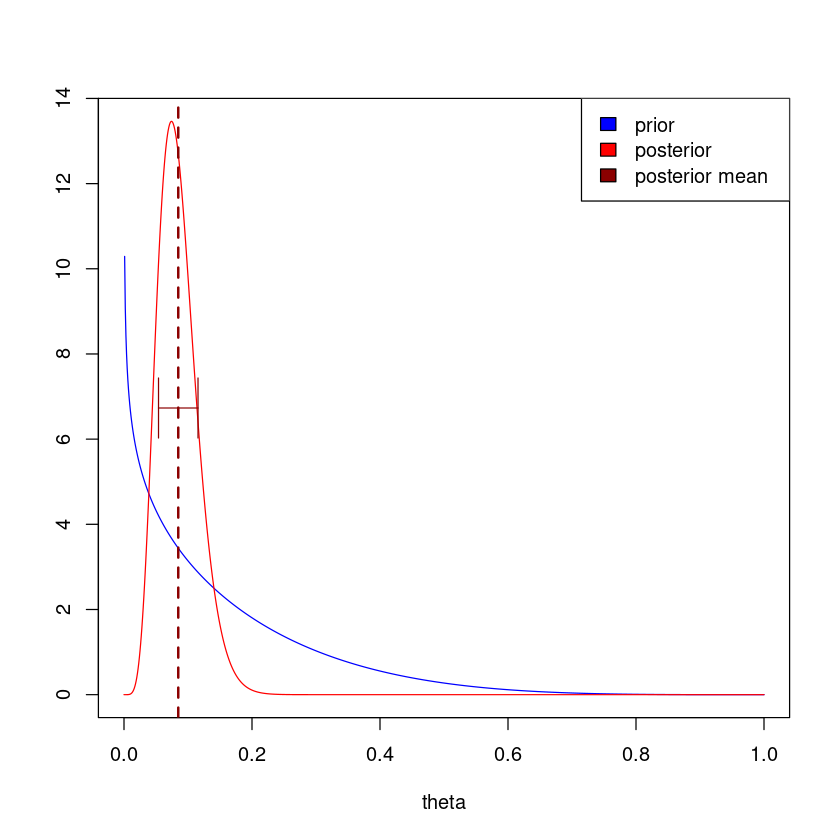

In [2]:
y <- 6
n <- 75

alpha <- 0.825765
beta <- 4.679337


alpha_post <- alpha + y
beta_post <- beta + n - y

theta <- seq(0,1,0.001)
prior <- dbeta(theta,alpha,beta)
posterior <- dbeta(theta,alpha_post,beta_post)

mean_posterior <- alpha_post/(alpha_post+beta_post)
std_posterior <- sqrt((alpha_post*beta_post)/(((alpha_post+beta_post)^2)*(alpha_post+beta_post+1)  ))

print("Mean of theta posterior distribution:")
print(mean_posterior)

plot(
    theta,prior,
    type='l',
    ylab="",
    col='blue',
    ylim=c(0,max(posterior))
)
lines(
    theta,posterior,
    col='red'
)
abline(
    v = mean_posterior,
    col='darkred',
    lty=2,
    lwd=2
)

arrows(
    x0 = mean_posterior - std_posterior,
    y0 = max(posterior)/2,
    x1 = mean_posterior + std_posterior,
    y1 = max(posterior)/2,
    code = 3,
    angle=90,
    col = 'darkred'
)

legend(
    "topright",
    c("prior","posterior","posterior mean"),
    fill = c("blue","red","darkred")
)

#### _(d) Perform a test of hypothesis assuming that if the probability of failing to the detect the desease in ill patients is greater or equal than 15%, the new test is no better that the traditional method. Test the sample at a 5% level of significance in the Bayesian way._ 

$$
H_0 : \theta_{new} > 0.15\\
H_1 : \theta_{new} \leq 0.15
$$

The null hypothesis is that the new treatment is no better than the previous one, i.e. the fraction $\theta_{new}$ of false negatives is greater than $15 \%$.  What is the probability of this happening?

Based on our posterior distribution for the parameter $\theta_{new}$, we can calculate what is the probability of it being larger than $15\%$:

$$
P(\theta_{new} > 0.15 | y = 6, n = 75) = \int_{0.15}^{1} P(\theta_{new}|y = 6, n = 75) d\theta_{new} = 1 - \int_0^{0.15} P(\theta_{new}|y = 6, n = 75) d\theta_{new}
$$

In [3]:
p_theta_greater <- 1 - pbeta(0.15,alpha_post,beta_post)
p_theta_greater

[1] 0.03127932

This is less than our predefined level of significance $\alpha=0.05$, therefore we reject the null hypothesis.

#### _(e) Perform the same hypothesis test in the classical frequentist way._

In the frequentist way, we have no probability distribution over the parameter $\theta_{new}$; either the parameter has some value or it has another. The null hypothesis is, again, that the parameter is greater than $15\%$; now, we select a test statistic, which will the probability of getting the data, or even more extreme cases ($y \leq 6 | n=75$), given the null hypothesis ($\theta_{new}=0.15$, since higher values decrease the probability):

$$
P(y \leq 6,n=75|\theta_{new}=0.15) = \sum_{i=0}^{6} P(y=i,n=75|\theta_{new}=0.15)
$$

we can do this using the already implemented R function:

In [4]:
binom.test(6,75,0.15,alternative="less")


	Exact binomial test

data:  6 and 75
number of successes = 6, number of trials = 75, p-value = 0.05435
alternative hypothesis: true probability of success is less than 0.15
95 percent confidence interval:
 0.0000000 0.1517971
sample estimates:
probability of success 
                  0.08 


p-value is higher than $\alpha = 0.05$; we cannot reasonably conclude that the result of the test is NOT due to chance alone, therefore we cannot reject the NULL hypothesis. Notice that $y=6$ is actually the critical value, because for $y=5$ we have:

In [5]:
binom.test(5,75,0.15,alternative="less")


	Exact binomial test

data:  5 and 75
number of successes = 5, number of trials = 75, p-value = 0.02342
alternative hypothesis: true probability of success is less than 0.15
95 percent confidence interval:
 0.0000000 0.1350712
sample estimates:
probability of success 
            0.06666667 


Which is lower than $\alpha=0.05$.

### Exercise 2

Ladislaus Josephovich Bortkiewicz was a Russian economist and statistician. He noted that the Poisson distribution can be very useful in applied statistics when describing low-frequency events in a large population. In a famous example he showed that the number of deaths by horse kick among the Prussian army follows the Poisson distribution.

Considering the following to sets of observations taken over a fixed large time interval in two different corps:

| $y$ death soldiers | $0$   | $1$  | $2$  | $3$  | $4$ | $\geq 5$ |
|--------------------|-----|----|----|----|---|----------|
| $n_1$ observations | 109 | 65 | 22 | 3  | 1 | 0        |
| $n_2$ observations | 144 | 91 | 32 | 11 | 2 | 0        |

#### _(a) assuming a uniform prior, compute and plot the posterior distribution for λ, the death rate over the measurement time. Determine the posterior mean, median and variance, and compute the 95% credibility interval._

Assuming an uniform prior means that the posterior has the same expression as the likelihood:

$$
P(\lambda | y) = P(y | \lambda) = \prod^{n_1}_i P(y_{obs}|\lambda) = \prod^{n_1}_i \frac{\lambda^{y_{obs}}e^{-\lambda}}{y_{obs}!} = Gamma(\lambda | \alpha = \sum y_i + 1, \beta = n_1 ) = k \lambda^{\alpha-1} e^{- \beta \lambda}
$$

[1] Mean:

[1] 0.615

[1] Variance:

[1] 0.003075

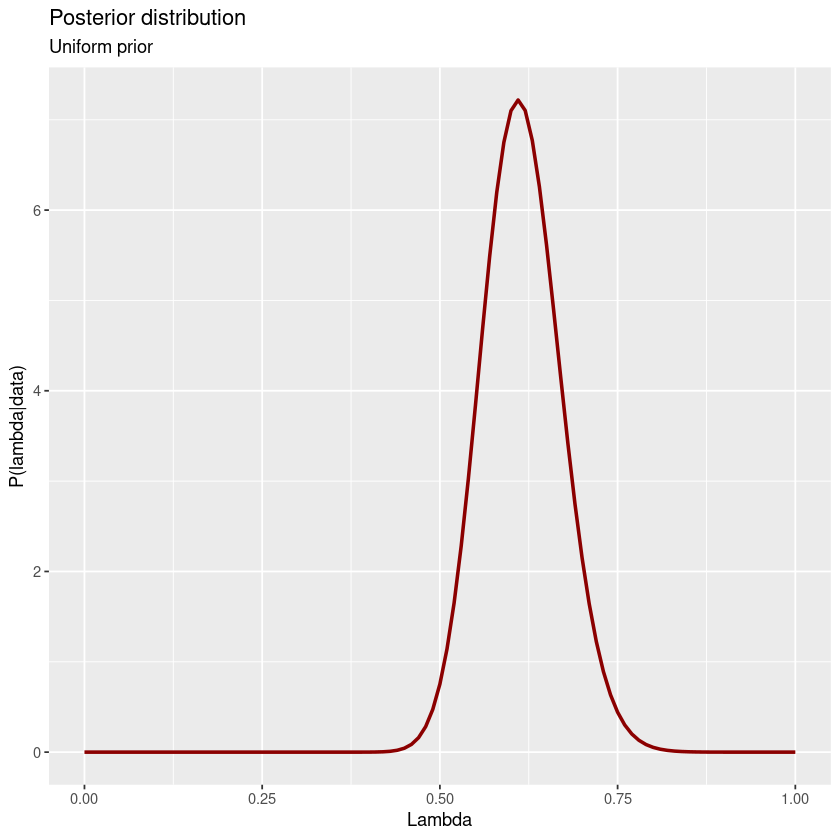

In [6]:
# start with the set of observations n1

data <- data.frame(y=c(0,1,2,3,4),n1=c(109,65,22,3,1),n2=c(144,91,32,11,2))
# if we wanted to account for both observations, we'd just do
beta <- sum(data$n1) # sum(data$n1) + sum(data$n2)
alpha <- sum(data$y * data$n1) + 1 # sum(data$y*data$n1) + sum(data$y*data$n2) + 1


plot <- ggplot() + geom_function(fun=dgamma,args=c(alpha,beta),colour="darkred",lwd=1) + labs(title="Posterior distribution",subtitle="Uniform prior",x="Lambda",y="P(lambda|data)")
plot

noquote("Mean:")
noquote(alpha/beta)

noquote("Variance:")
noquote(alpha/(beta^2)) 

In order to find the median, since there is no closed form solution to it, we will find it by running an algorithm to determine the root of the function 

$$
\int_0^{\lambda} Gamma(\lambda'|\alpha,\beta) d\lambda' - \frac{1}{2} = 0
$$

In [7]:
func <- function(lambda) {
    return(pgamma(lambda,alpha,beta)-0.5) 
}

res <- uniroot(func,c(0,1))
res$root

[1] 0.6133137

While we choose the credibility interval to be the smallest possible.

[1] 0.51

[1] 0.7269771

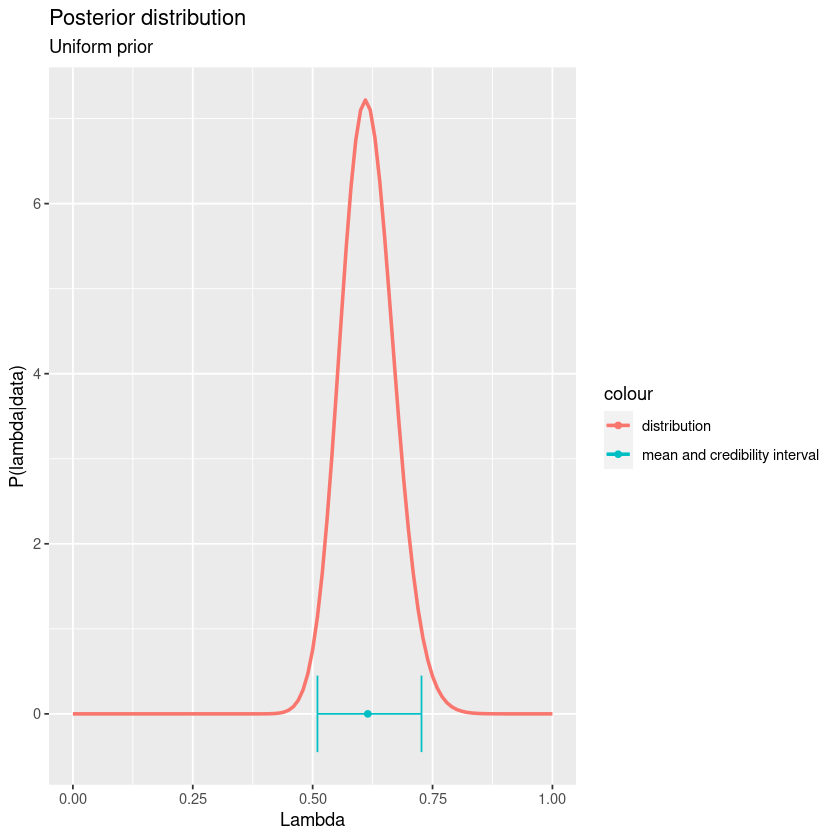

In [8]:
a.max <- qgamma(0.05,alpha,beta)
a.seq <- seq(0,a.max,0.01)
best.diff <- 1000

for (a in a.seq) {
    b <- qgamma(pgamma(a,alpha,beta) + 0.95,alpha,beta)
    if (abs(b-a)<best.diff) {
        best.a <- a
        best.b <- b
        best.diff <- abs(b-a)
    }
}

best.a
best.b

plot <- ggplot() + geom_function(fun=dgamma,args=c(alpha,beta),aes(colour="distribution"),lwd=1) + labs(title="Posterior distribution",subtitle="Uniform prior",x="Lambda",y="P(lambda|data)")
plot <- plot  + geom_errorbarh(aes(xmin=best.a,xmax=best.b,y=0,colour="mean and credibility interval")) + xlim(0,1) + geom_point(aes(x=alpha/beta,colour='mean and credibility interval'),y=0)

plot

#### _(b) assuming now a Jeffreys’ prior, compute and plot the posterior distribution for λ, the death rate over the measurement time. Determine the posterior mean, median and variance, and compute the 95% credibility interval._

Jeffreys' prior:

$$
P(\lambda) \propto 1/\sqrt{\lambda} \\
 \lambda \geq 0
$$

The Jeffrey prior simply adds a $-\frac{1}{2}$ term to $\alpha$, that is now defined as $\alpha = \sum y_i + 1/2$.

[1] Mean:

[1] 0.6125

[1] Var:

[1] 0.0030625

[1] Median:

[1] 0.6108322

[1] Confidence interval:

[1] a = 

[1] 0.51

[1] b = 

[1] 0.7271521

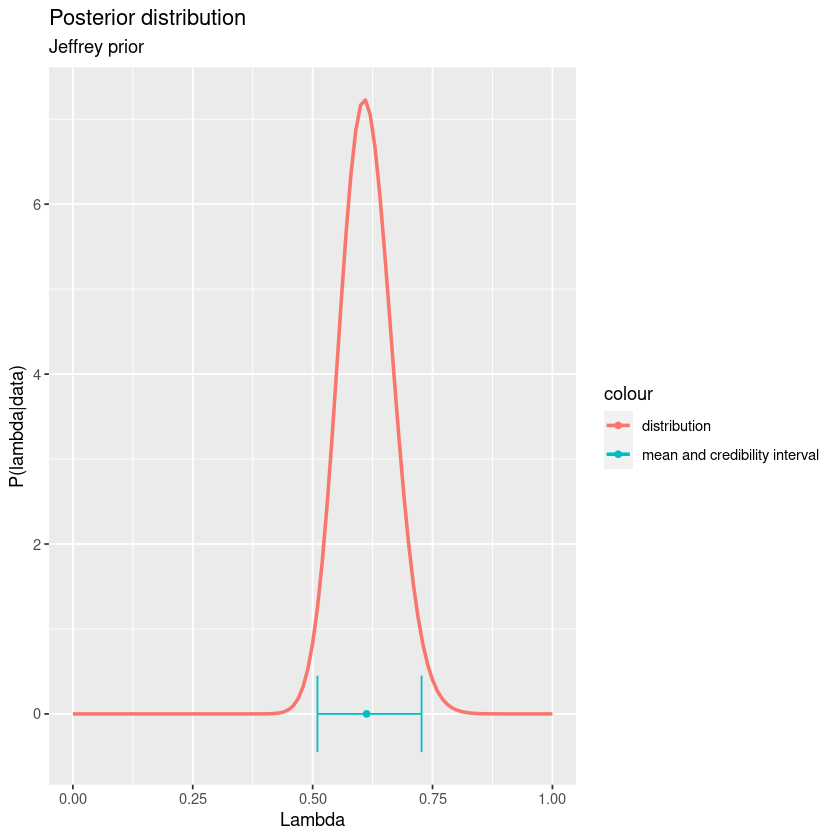

In [9]:
# same as before, we are considering the first row n1
alpha.jeffrey <- alpha - 0.5
mean.jeffrey <- alpha.jeffrey/beta
var.jeffrey <- alpha.jeffrey/(beta^2)

noquote("Mean:")
noquote(mean.jeffrey)
noquote("Var:")
noquote(var.jeffrey)

func.jeffrey <- function(lambda) {
    return(pgamma(lambda,alpha.jeffrey,beta)-0.5) 
}

res.jeffrey <- uniroot(func.jeffrey,c(0,1))
median.jeffrey <- res.jeffrey$root

noquote("Median:")
noquote(median.jeffrey)



a.jeffrey.max <- qgamma(0.05,alpha.jeffrey,beta)
a.jeffrey.seq <- seq(0,a.jeffrey.max,0.01)
best.diff.jeffrey <- 1000

for (a in a.jeffrey.seq) {
    b <- qgamma(pgamma(a,alpha.jeffrey,beta) + 0.95,alpha.jeffrey,beta)
    if (abs(b-a)<best.diff.jeffrey) {
        best.a.jeffrey <- a
        best.b.jeffrey <- b
        best.diff.jeffrey <- abs(b-a)
    }
}

noquote("Confidence interval:")
noquote("a = ")
noquote(best.a.jeffrey)
noquote("b = ")
noquote(best.b.jeffrey)

plot <- ggplot() + geom_function(fun=dgamma,args=c(alpha.jeffrey,beta),aes(colour="distribution"),lwd=1) + labs(title="Posterior distribution",subtitle="Jeffrey prior",x="Lambda",y="P(lambda|data)")
plot <- plot  + geom_errorbarh(aes(xmin=best.a.jeffrey,xmax=best.b.jeffrey,y=0,colour="mean and credibility interval")) + xlim(0,1) + geom_point(aes(x=mean.jeffrey,colour='mean and credibility interval'),y=0)

plot

### Exercise 3

A study on water quality of streams, a high level of bacter X was defined as a level greater than $100$ per $100 ml$ of stream water. $n = 116$ samples were taken from streams having a high environmental impact on pandas. Out of these, $y = 11$ had a high bacter X level.

Indicating with $p$ the probability that a sample of water taken from the stream has a high bacter X level,

#### _(a) find the frequentist estimator for p_

The frequentist unbiased estimator for $p$ is
$$
\hat{p}_F = \frac{y}{n} = \frac{11}{116}
$$

#### _(b) using a $Beta(1, 10)$ prior for $p$, calculate and (???) posterior distribution $P(p|y)$._

When using a $Beta(\alpha,\beta)$ prior for a Bernoulli likelihood, the posterior distribution is again a Beta distribution (since it's a conjugate prior) with hyperparameters $Beta_{post}(\alpha+y,\beta + n - y)$ so we have

$$
P(p|y,n) = Beta(1+11,10+116-11) = Beta(12,115)
$$

[1] 0.09448819

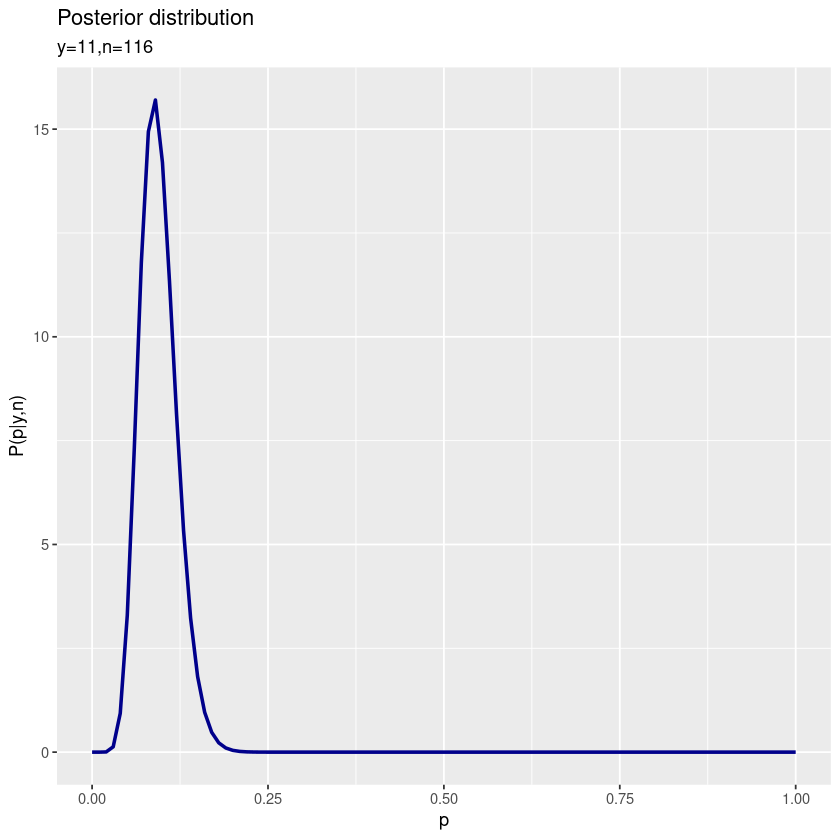

In [10]:
mean <- 12/(12+115)
mean

plot <- ggplot() + geom_function(fun=dbeta,args=c(12,115),col="darkblue",lwd=1) + labs(title="Posterior distribution",subtitle="y=11,n=116",y="P(p|y,n)",x="p")
plot

#### _(c) find the bayesian estimator for p, the posterior mean and variance, and a 95% credible interval_

If we choose the best estimate for $p$ to be the mean of its posterior bayesian distribution, we have

$$
\hat{p}_B = E[p|y,n] = \frac{\alpha_{post}}{\alpha_{post} + \beta_{post}} = \frac{12}{12+115} = 9.449... \cdot 10^{-2}
$$

Its variance being:

$$
Var[\hat{p}_B] = \frac{\alpha_{post} \beta_{post}}{(\alpha_{post} + \beta_{post})^2 (\alpha_{post} + \beta_{post} + 1)} = \frac{12 \cdot 115}{(12+115)^2(12+115+1)} = 0.06684388 ... \cdot 10^{-2}
$$

and again we choose the credible interval to be the smallest possible with probability $0.95$:

In [11]:
alpha <- 12
beta <- 115

a.max <- qbeta(0.05,alpha,beta)
a.seq <- seq(0,a.max,0.01)
best.diff <- 1000

for (a in a.seq) {
    b <- qbeta(pbeta(a,alpha,beta) + 0.95,alpha,beta)
    if (abs(b-a)<best.diff) {
        best.a <- a
        best.b <- b
        best.diff <- abs(b-a)
    }
}

best.a
best.b

[1] 0.05

[1] 0.1504851

#### _(d) test the hypothesis_

$$
H_0 : p = 0.1 \\
H_1 : p \neq 0.1
$$

#### _at 5% level of significance with both the frequentist and bayesian approach_

##### Frequentist approach

As always, we need to calculate the NULL distribution of the test statistic which is the sampling distribution, given that the NULL hypothesis is true. We can do this using R's `binom.test` routine:

In [12]:
binom.test(x=11,n=116,p=0.1,alternative="two.sided")


	Exact binomial test

data:  11 and 116
number of successes = 11, number of trials = 116, p-value = 1
alternative hypothesis: true probability of success is not equal to 0.1
95 percent confidence interval:
 0.04829409 0.16333954
sample estimates:
probability of success 
            0.09482759 


The sample is compatible with the null hypothesis, thus we do not reject it.

##### Bayesian approach

After seeing the data, the posterior distribution encapsulates our belief about the value of the parameter. So, if we want to minimize the error of rejecting a true hypothesis to less than our significance level $\alpha$, we build a 95% credibility interval, i.e. an interval $I$ over the domain of the distribution whose probability is $P(I)=0.95$. We already did that:

In [13]:
p0 <- 0.1

noquote("The p0 of the null hypothesis lies within a 95% credibility interval")
p0 > best.a & p0 < best.b

[1] The p0 of the null hypothesis lies within a 95% credibility interval

[1] TRUE

a new measurement, performed one month later on $n = 165$ water samples, gives $y = 9$ high bacter X level

#### _(e) find the frequentist estimator for $p$._

Again:

$$
\hat{p}_F = \frac{9}{165}
$$

#### _(f) find a bayesian estimator for $p$, assuming both a $Beta(1, 10)$ prior for $p$, and assuming the posterior probability of the older measurement as the prior for the new one._

##### _• $Beta(1,10)$ as prior_

Again, using a Beta distribution as a prior for a Bernoulli likelihood results in a Beta posterior with
$$
\alpha_{post} = \alpha + y = 1 + 9 = 10\\
\beta_{post} = \beta + n - y = 10 +165 - 9 = 166 
$$
Assuming the bayesian estimator to be the mean of this distribution we have:

$$
\hat{p}_B = \frac{10}{10+166}=0.056\overline{81}
$$

##### _• previous posterior as new prior_

The posterior of the older measurement is a $Beta$ distribution with $\alpha_{old}=12$ and $\beta_{old}=115$.
Again, using this as a prior distribution for $p$ results in a new $Beta$ distribution with 
$$
\alpha=\alpha_{old} + y
= 12 + 9=21
$$ 
and 
$$
\beta=\beta_{old} + n - y=115 + 165 - 9=271
$$

And we have

$$
\hat{p}_B = \frac{21}{21+271}= 0.07\overline{19178082}
$$

#### _(g) find the bayesian estimator for $p$, the posterior mean and variance, and a 95% credible interval_

Considering all data so far (which is the same as considering the posterior with the previous one as a prior), we already have the best estimator; its variance, also from Beta distribution theory, is:

$$
Var[\hat{p}_B] = \frac{\alpha \beta}{(\alpha+\beta)^2 (\alpha + \beta + 1)} = \frac{21\cdot271}{(21 + 271)^2(21 + 271 + 1)} = 0.000227800809147193
$$

in order to find the 95% credible interval we deploy the same technique as before to find the smallest interval:

In [14]:
alpha <- 21
beta <- 271

a.max <- qbeta(0.05,alpha,beta)
a.seq <- seq(0,a.max,0.01)
best.diff <- 1000

for (a in a.seq) {
    b <- qbeta(pbeta(a,alpha,beta) + 0.95,alpha,beta)
    if (abs(b-a)<best.diff) {
        best.a <- a
        best.b <- b
        best.diff <- abs(b-a)
    }
}

best.a
best.b

[1] 0.04

[1] 0.09968144

#### _(h) test the hypotesis_
$$
H_0 : p=0.1 \\
H_1 : p\neq 0.1
$$
#### _at 5% level of significance with both the frequentist and bayesian approach_ 

##### Frequentist approach
Again, we can compute the p-value for the binomial likelihood with R routine:

In [15]:
# considering only new data: y = 9 and n = 165
binom.test(9,165,0.1,alternative='two.sided')


	Exact binomial test

data:  9 and 165
number of successes = 9, number of trials = 165, p-value = 0.05112
alternative hypothesis: true probability of success is not equal to 0.1
95 percent confidence interval:
 0.02524192 0.10101679
sample estimates:
probability of success 
            0.05454545 


This second set of measurements is compatible with the NULL hypothesis, just over our significance level. What if we consider both measurements at once?

In [16]:
# considering both measurements: y = 9 + 11 = 20 and n = 165 + 116 = 281
binom.test(20,281,0.1,alternative='two.sided')


	Exact binomial test

data:  20 and 281
number of successes = 20, number of trials = 281, p-value = 0.1119
alternative hypothesis: true probability of success is not equal to 0.1
95 percent confidence interval:
 0.04401442 0.10778463
sample estimates:
probability of success 
            0.07117438 


Again, the NULL hypothesis holds. 

##### Bayesian approach

We need to see if $p$ from the NULL hypothesis lies within a 95% credibility interval in our posterior distribution. We already computed it:


In [17]:
p0 <- 0.1

noquote("The p0 of the null hypothesis lies within a 95% credibility interval")
p0 > best.a & p0 < best.b

[1] The p0 of the null hypothesis lies within a 95% credibility interval

[1] FALSE

Since the upper limit for the credibility interval we built is $b<0.1$, we reject the NULL hypothesis.

### Exercise 4

analyze the data of Exercise 1 using a MCMC with JAGS (solve only point a of Ex 1)

Let's consider again the problem in exercise 1. We want to infere the probability parameter $p$ (earlier referred to as $\theta$) of an event occurring (the false negative) in a Binomial distribution, given the observation of $y=6$ false negative occurring in $n=75$ tests. First, we define the model in a `.bug` file:

In [18]:
cat(system("cat ex6_4.bug",intern=TRUE),sep="\n") # print it out

model {
    # likelihood
    for (i in 1:length(X)){
        X[i] ~ dbern(p);
    }

    # uniform prior for p
    p ~ dbeta(1,1);

    # predictions, given p
    y ~ dbin(p,n_next);
}


In [19]:
# vector of observations
X <- rep(0,75)
X[1:6] <- 1
X <- sample(X)
X

data <- NULL
data$X <- X

data$n_next <- 10 # number of predictions

[1] 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
[39] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0

In [20]:
jm <- jags.model("ex6_4.bug",data)
update(jm,1000)
chain <- coda.samples(jm,c("p","y"),n.iter=10000)
print(summary(chain))

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 75
   Unobserved stochastic nodes: 2
   Total graph size: 79

Initializing model


Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

     Mean      SD  Naive SE Time-series SE
p 0.09067 0.03232 0.0003232      0.0003232
y 0.91320 0.96507 0.0096507      0.0096507

2. Quantiles for each variable:

     2.5%     25%     50%    75%  97.5%
p 0.03803 0.06728 0.08718 0.1105 0.1639
y 0.00000 0.00000 1.00000 1.0000 3.0000



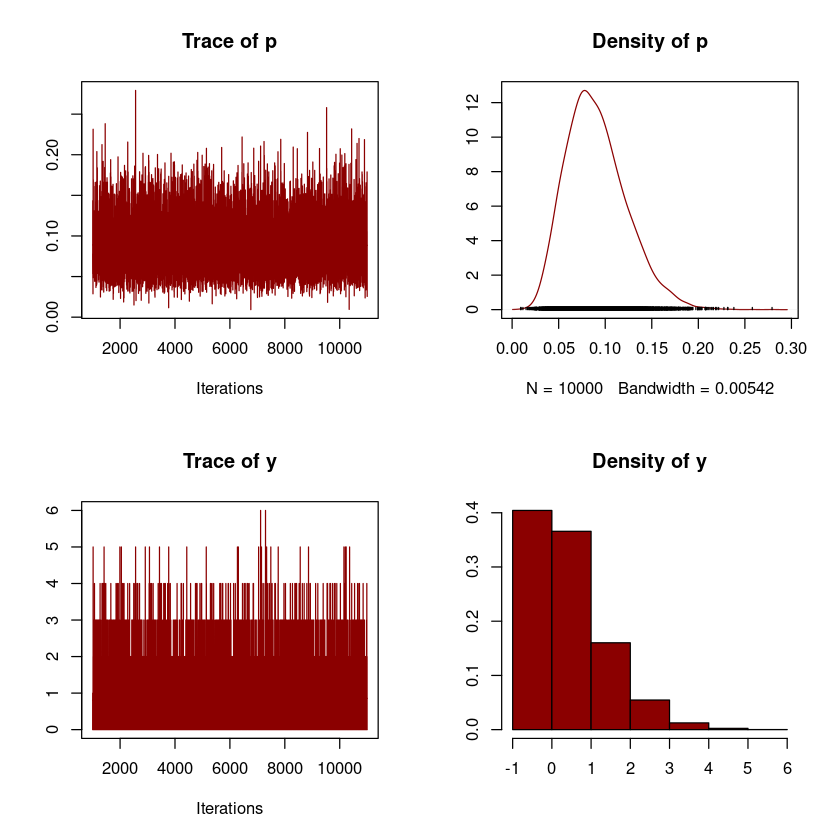

In [21]:
plot(chain,col='darkred')

We can now evaluate the most probable $p$ by taking either a mean (shown in the summary) or the mode of its distribution in the sampling set.

### Exercise 5
_analyze the data of Exercise 2 using a MCMC with JAGS_

Exercise 2 was about inferring the parameter $\lambda$ in a Poisson distribution, first assuming a uniform prior on lambda then imposing a Jeffrey's prior ($g(\lambda) \propto \lambda^{-1/2}$). Let's start by the uniform, and define the JAGS model:

In [22]:
cat(system("cat ex6_5_uniform.bug",intern=TRUE),sep="\n") # print it out

model {
    for (i in 1:length(X)){
        X[i] ~ dpois(lambda);
    }
    # same trick as shown in slides: 
    # use a very slowly decaying exponential distribution
    # as a uniform one
    lambda ~ dexp(0.00001) ;

    Y ~ dpois(lambda);
}


And now we define the data:

In [23]:
# observations: listed as the counts times the number of counts observed
data.observed <- data.frame(y=c(0,1,2,3,4),n1=c(109,65,22,3,1),n2=c(144,91,32,11,2))
data.observed

# to build the obervations vector, we need to construct a sequence of observations with as many occurrences as the count in n1 (or n2 or both)
X <- NULL
for (i in data.observed$y) {
    X<-c(X,rep(i,data.observed$n1[i+1]))
}

data <- NULL
data$X <- X

jm <- jags.model("ex6_5_uniform.bug",data)

y,n1,n2
<dbl>,<dbl>,<dbl>
0,109,144
1,65,91
2,22,32
3,3,11
4,1,2


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 200
   Unobserved stochastic nodes: 2
   Total graph size: 203

Initializing model



And now we run the sampler:

In [24]:
update(jm,1000)
chain <- coda.samples(jm , c(" lambda ", "Y"), n.iter=10000)
summary(chain)


Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

         Mean      SD  Naive SE Time-series SE
Y      0.6107 0.78537 0.0078537      0.0078537
lambda 0.6157 0.05547 0.0005547      0.0005547

2. Quantiles for each variable:

         2.5%    25%    50%    75%  97.5%
Y      0.0000 0.0000 0.0000 1.0000 2.0000
lambda 0.5127 0.5772 0.6137 0.6512 0.7317


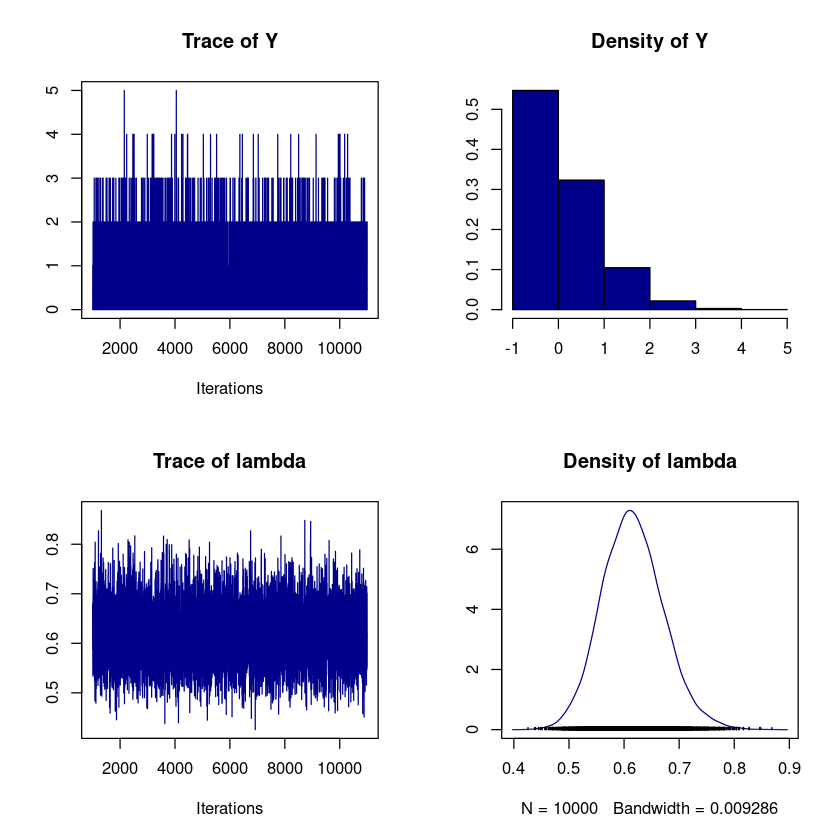

In [25]:
plot(chain,col="darkblue")

As we can see, we can a pretty consistent result with the analytical one, that inferred $E[\lambda] = 0.6133\dots$. 
Now, in order to implement a Jeffrey prior we would need to modify the BUGS file in such a way to draw $\lambda \sim \lambda^{-1/2}$; unfortunately this is not easily implemented in JAGS because improper priors are not defined in BUGS' language.

### Exercise 6

_analyze the data of Exercise 3 using a MCMC with JAGS (solve point b and c)_

Again, this is a case of parameter estimation for a Binomial distribution. We have $y=11$ critical samples out of $n=116$ trials. Let's again set up the model with the proper $Beta(1,10)$ prior for $p$ (the probability of a sample being critical):

In [26]:
cat(system("cat ex6_6.bug",intern=TRUE),sep="\n") # print it out

model {
    # likelihood
    for (i in 1:length(X)){
        X[i] ~ dbern(p);
    }

    # uniform prior for p
    p ~ dbeta(1,10);

} 


In [27]:
# build the observation vector
X <- sample(c(rep(1,11),rep(0,116-11)))
data <- NULL
data$X <- X
# build jags model
jm <- jags.model("ex6_6.bug",data)
update(jm,1000)
chain <- coda.samples(jm,c("p"),n.iter=10000)
print(summary(chain))

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 116
   Unobserved stochastic nodes: 1
   Total graph size: 119

Initializing model


Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     0.0946293      0.0257410      0.0002574      0.0002574 

2. Quantiles for each variable:

   2.5%     25%     50%     75%   97.5% 
0.05118 0.07622 0.09244 0.11068 0.15139 



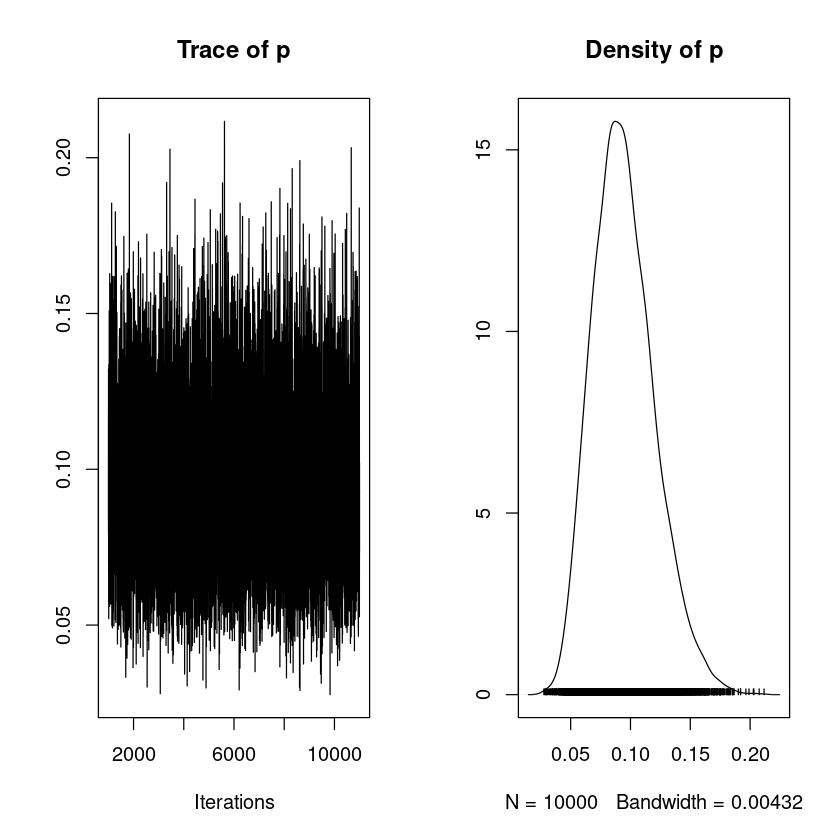

In [28]:
plot(chain)

Again, the mean is compatible with the analytical result previously obtained. The $2.5\%$ and $97.5\%$ quantiles can be used as a $95\%$credibility interval.